In [12]:
# ======= BƯỚC 1: Import các thư viện cần thiết =======
from pyspark.sql import SparkSession
from pyspark.ml.feature import VectorAssembler, StandardScaler, OneHotEncoder, StringIndexer
from pyspark.ml.classification import RandomForestClassifier
from pyspark.ml import Pipeline
from pyspark.ml.evaluation import BinaryClassificationEvaluator, MulticlassClassificationEvaluator
from pyspark.sql.functions import col
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

In [13]:
# ======= BƯỚC 2: Khởi tạo SparkSession =======
spark = SparkSession.builder.appName("RandomForest").getOrCreate()

In [14]:
# ======= BƯỚC 3: Load dữ liệu =======
df = spark.read.csv(r"D:/Năm 3 - HK2/Dữ liệu lớn/DeepStroke/data/processed_data/preprocess.csv", header=True, inferSchema=True)

In [15]:
# ======= BƯỚC 4: Tiền xử lý =======
# Cột mục tiêu
target_col = "HadStroke"
feature_cols = [col for col in df.columns if col != target_col]

# Chia dữ liệu thành tập train/test
train_data, test_data = df.randomSplit([0.8, 0.2], seed=42)

In [16]:
# ======= BƯỚC 5: Xây dựng pipeline =======
# Tạo pipeline với các bước xử lý dữ liệu và mô hình
model = RandomForestClassifier(labelCol=target_col, featuresCol="scaled_features")
pipeline = Pipeline(stages=indexers + [encoder, assembler, scaler, model])

# Kiểm tra lại tên các cột có trong dữ liệu
print(train_data.columns)

# Huấn luyện mô hình trên dữ liệu huấn luyện
model = pipeline.fit(train_data)

['Sex', 'GeneralHealth', 'HeightInMeters', 'WeightInKilograms', 'BMI', 'HadHeartAttack', 'HadAngina', 'HadStroke', 'HadAsthma', 'HadSkinCancer', 'HadCOPD', 'HadDepressiveDisorder', 'HadKidneyDisease', 'HadArthritis', 'DeafOrHardOfHearing', 'BlindOrVisionDifficulty', 'DifficultyConcentrating', 'DifficultyWalking', 'DifficultyDressingBathing', 'DifficultyErrands', 'SmokerStatus', 'ECigaretteUsage', 'ChestScan', 'AlcoholDrinkers', 'HIVTesting', 'FluVaxLast12', 'PneumoVaxEver', 'HighRiskLastYear', 'CovidPos', 'AgeMin', 'AgeMax', 'TetanusLast10TdapIndex', 'HadDiabetesIndex']


In [17]:
# ======= BƯỚC 6: Dự đoán trên tập kiểm tra =======
predictions = model.transform(test_data)

In [18]:
# ======= BƯỚC 7: Đánh giá mô hình =======
# Đánh giá AUC (đúng với BinaryClassificationEvaluator)
evaluator = BinaryClassificationEvaluator(labelCol=target_col, rawPredictionCol="prediction")
auc = evaluator.evaluate(predictions)

# Đánh giá độ chính xác (accuracy) - dùng MulticlassClassificationEvaluator
accuracy_evaluator = MulticlassClassificationEvaluator(labelCol=target_col, predictionCol="prediction", metricName="accuracy")
accuracy = accuracy_evaluator.evaluate(predictions)

# Đánh giá Precision và Recall - Sử dụng MulticlassClassificationEvaluator
precision_evaluator = MulticlassClassificationEvaluator(labelCol=target_col, predictionCol="prediction", metricName="weightedPrecision")
precision = precision_evaluator.evaluate(predictions)

recall_evaluator = MulticlassClassificationEvaluator(labelCol=target_col, predictionCol="prediction", metricName="weightedRecall")
recall = recall_evaluator.evaluate(predictions)

# Đánh giá F1-score
f1_evaluator = MulticlassClassificationEvaluator(labelCol=target_col, predictionCol="prediction", metricName="f1")
f1_score = f1_evaluator.evaluate(predictions)

# In kết quả đánh giá
print(f"AUC: {auc:.4f}")
print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1-score: {f1_score:.4f}")


AUC: 0.7418
Accuracy: 0.7417
Precision: 0.7458
Recall: 0.7417
F1-score: 0.7406


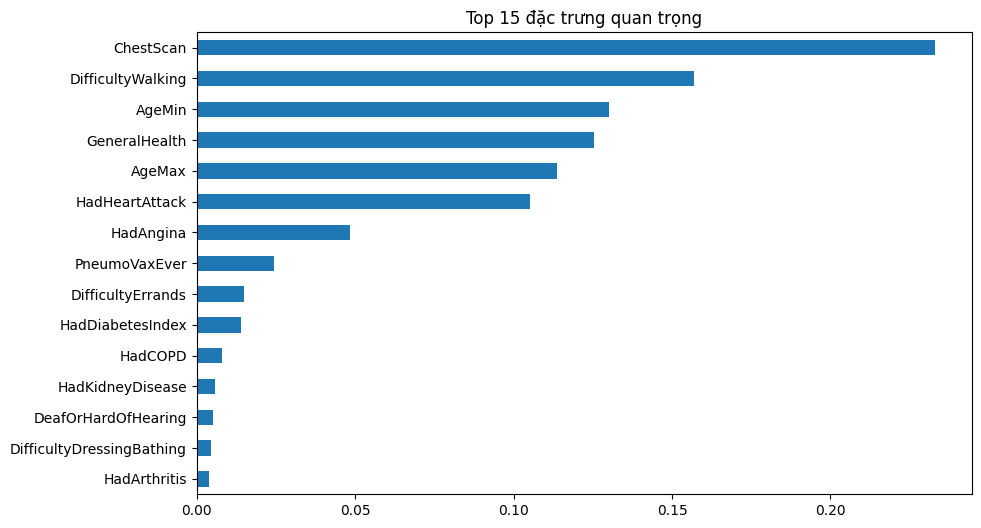

Bảng các đặc trưng quan trọng:
ChestScan                    0.232922
DifficultyWalking            0.156884
AgeMin                       0.130256
GeneralHealth                0.125309
AgeMax                       0.113693
HadHeartAttack               0.105083
HadAngina                    0.048425
PneumoVaxEver                0.024351
DifficultyErrands            0.014873
HadDiabetesIndex             0.014025
HadCOPD                      0.007946
HadKidneyDisease             0.005918
DeafOrHardOfHearing          0.005070
DifficultyDressingBathing    0.004452
HadArthritis                 0.003988
DifficultyConcentrating      0.002886
SmokerStatus                 0.002102
AlcoholDrinkers              0.000702
HeightInMeters               0.000257
BlindOrVisionDifficulty      0.000211
ECigaretteUsage              0.000161
BMI                          0.000154
WeightInKilograms            0.000140
HadAsthma                    0.000073
HadSkinCancer                0.000058
HighRiskLastYear   

In [19]:
# ======= BƯỚC 8: Hiển thị top đặc trưng quan trọng =======
# Lấy feature importances từ RandomForestClassifier
random_forest_model = model.stages[-1]  # Model cuối cùng trong pipeline là RandomForestClassifier
importances = random_forest_model.featureImportances

# Chuyển thành pandas Series để dễ dàng hiển thị
feat_imp = pd.Series(importances.toArray(), index=feature_cols)
feat_imp = feat_imp.sort_values(ascending=False)

# Vẽ đồ thị các đặc trưng quan trọng
plt.figure(figsize=(10, 6))
feat_imp.head(15).plot(kind='barh')
plt.title("Top 15 đặc trưng quan trọng")
plt.gca().invert_yaxis()  # Đảo ngược trục y để đặc trưng quan trọng nhất ở trên cùng
plt.show()

# Hiển thị bảng giá trị các đặc trưng quan trọng
print("Bảng các đặc trưng quan trọng:")
print(feat_imp)

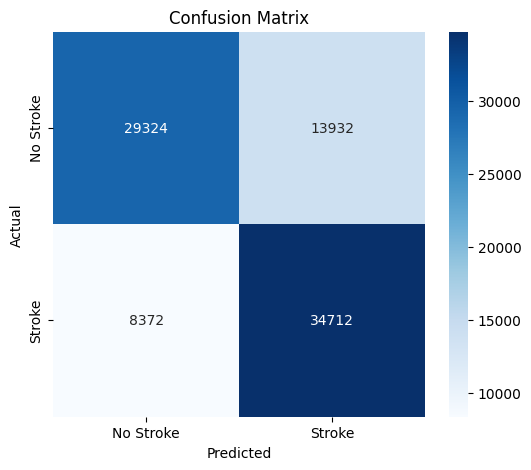

In [20]:
# ======= BƯỚC 9: Hiển thị confusion matrix =======
from sklearn.metrics import confusion_matrix
import seaborn as sns

# Chuyển kết quả dự đoán và nhãn thực tế từ PySpark sang Pandas DataFrame
y_true = predictions.select(target_col).toPandas()
y_pred = predictions.select("prediction").toPandas()

# Tính confusion matrix
cm = confusion_matrix(y_true, y_pred)

# Vẽ confusion matrix dưới dạng heatmap
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=["No Stroke", "Stroke"], yticklabels=["No Stroke", "Stroke"])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()
